In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importamos las librerias necesarias

In [2]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/exams.csv")
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


In [5]:
data['race/ethnicity'] = data['race/ethnicity'].map({'group A': 1, 'group B': 2, 'group C': 3, 'group D': 4, 'group E': 5})

In [6]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,1,high school,standard,completed,67,67,63
1,female,4,some high school,free/reduced,none,40,59,55
2,male,5,some college,free/reduced,none,59,60,50
3,male,2,high school,standard,none,77,78,68
4,male,5,associate's degree,standard,completed,78,73,68


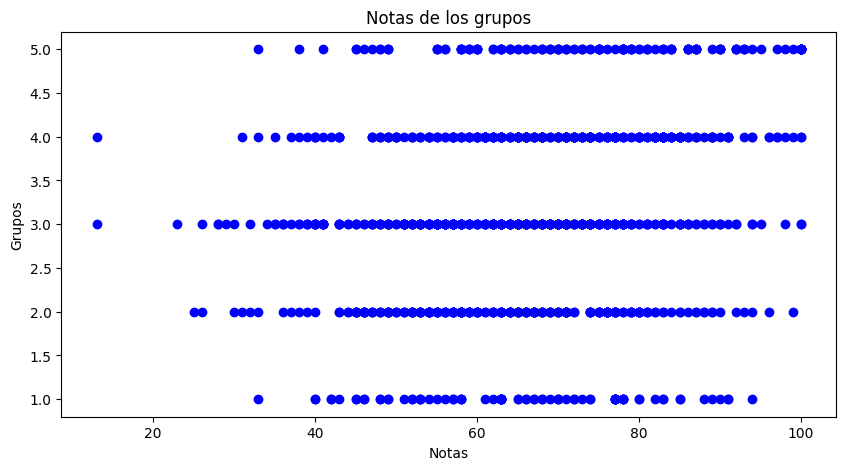

In [7]:
# Seleccionar la columna "test preparation course"
group = data['race/ethnicity'].values

# Crear una variable para las notas correspondientes
score = data['math score'].values

# Crear una figura y un eje de subplots
fig, ax = plt.subplots(figsize=(10, 5))

# Graficar los datos de notas como puntos
ax.scatter(score, group, marker='o', color='blue')  # 'o' especifica el marcador como un círculo

# Agregar etiquetas a los ejes y al gráfico
ax.set_xlabel('Notas')
ax.set_ylabel('Grupos')
ax.set_title('Notas de los grupos')

plt.show()

In [8]:
# convertir datos en formato de matriz y normalizarlos dividiéndolos con el valor máximo
all_data = data['math score'].values.astype(float)

test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [9]:
train_data.shape, test_data.shape

((988,), (12,))

# Normalizacion
Normalizamos los datos en el rango específico de (-1, 1).

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[ 0.24137931]
 [-0.37931034]
 [ 0.05747126]
 [ 0.47126437]
 [ 0.49425287]]
[[0.03448276]
 [0.14942529]
 [0.40229885]
 [0.49425287]
 [0.49425287]]


In [11]:
# Ya normalizados
train_data_normalized.shape

(988, 1)

#Convertir datos a Tensores

In [12]:
# Convertir los datos normalizados de TRAIN en tensores
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized.shape

torch.Size([988])

# Funcion para crear secuencias

In [13]:
# Función para crear secuencia y etiqueta para datos de entrenamiento
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

El tamaño de la ventana de tiempo (train_window) es el número de puntos de datos que se utilizan para predecir el siguiente punto de datos en una serie temporal. En este caso, el tamaño de la ventana de tiempo es 12, lo que significa que se utilizan los últimos 12 puntos de datos para predecir el siguiente punto de datos.

In [14]:
train_window = 12 # tamaño de la ventana de tiempo
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

# Definiendo Modelo DeepRNN

In [15]:
class DeepRNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        # Definir una capa RNN con input_size entradas y hidden_layer_size salidas
        self.rnn = nn.RNN(input_size, hidden_layer_size)
        # Agregar una capa Dropout
        self.dropout = nn.Dropout(p=0.2)
        # Definir una capa lineal con hidden_layer_size entradas y output_size salidas
        self.linear = nn.Linear(hidden_layer_size, output_size)
        # Inicializar la capa oculta con un tensor de ceros
        self.hidden_cell = torch.zeros(1, 1, self.hidden_layer_size)

    def forward(self, input_seq):
        # Pasar la secuencia de entrada a través de la capa RNN
        rnn_out, self.hidden_cell = self.rnn(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        # Agregar la capa Dropout
        dropout_out = self.dropout(rnn_out)
        # Pasar la salida de la capa RNN a través de la capa lineal para producir las predicciones
        predictions = self.linear(dropout_out.view(len(input_seq), -1))
        # Devolver la última predicción
        return predictions[-1]

In [16]:
model=DeepRNN()
model

DeepRNN(
  (rnn): RNN(1, 100)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [17]:
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [18]:
epochs = 100
# Ciclo de entrenamiento
for i in range(epochs + 1):
  # Ciclo de entrenamiento para cada secuencia de entrada
  for seq,label in train_inout_seq:
    # Reiniciar los gradientes
    optimizer.zero_grad()
    # Reiniciar el estado oculto de la red
    model.hidden_cell=(torch.zeros(1,1,model.hidden_layer_size))
    # Propagación hacia adelante a través de la red
    y_pred=model(seq)
    # Calcular la pérdida para la predicción actual
    single_loss=loss_function(y_pred,label)
    # Propagación hacia atrás de la pérdida
    single_loss.backward()
    # Actualizar los pesos de la red
    optimizer.step()
  # Imprimir la pérdida cada 5 épocas
  if i%25==0:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
# Imprimir la pérdida final
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.10784199
epoch:  25 loss: 0.07476383
epoch:  50 loss: 0.07611974
epoch:  75 loss: 0.22768597
epoch: 100 loss: 0.26255733
epoch: 100 loss: 0.2625573277


In [19]:
# Obtener los últimos datos de entrenamiento normalizados
test_inputs = train_data_normalized[-train_window:].tolist()

# Establecer el modelo en modo de evaluación
model.eval()

for i in range(test_data_size):
    # Crear una secuencia de entrada a partir de los últimos datos de prueba
    seq = torch.FloatTensor(test_inputs[-train_window:])
    # Desactivar el cálculo de gradientes para la predicción
    with torch.no_grad():
        # Establecer el estado oculto inicial en cero
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size))
        # Realizar la predicción y agregarla a los datos de prueba
        test_inputs.append(model(seq).item())

# Invertir la normalización y obtener las predicciones reales
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))

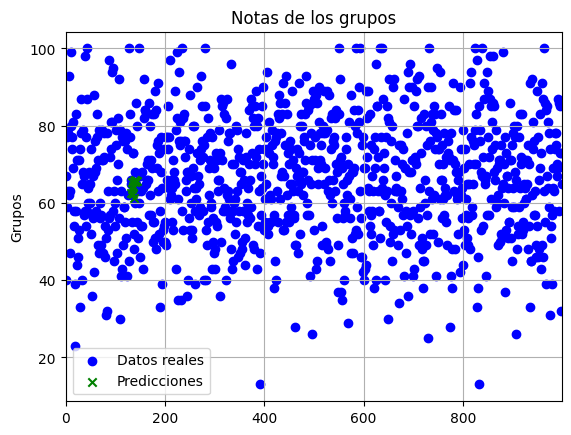

In [32]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(132, 144, 1)

plt.title("Notas de los grupos")
plt.ylabel("Grupos")
plt.grid(True)
plt.autoscale(axis='x', tight=True)

# Utiliza scatter para mostrar puntos en lugar de plot
plt.scatter(range(len(data['math score'])), data['math score'], color='blue', marker='o', label='Datos reales')
plt.scatter(x, actual_predictions, color='green', marker='x', label='Predicciones')

plt.legend()  # Agrega una leyenda para diferenciar las series de datos
plt.show()


In [21]:
# Calcular la pérdida en los datos de prueba
test_data_normalized = scaler.transform(test_data.reshape(-1, 1))
test_inputs = test_data_normalized[:-1]
test_labels = test_data_normalized[1:]
with torch.no_grad():
    test_predictions = model(torch.FloatTensor(test_inputs).view(-1).unsqueeze(1)).view(-1)
test_loss = loss_function(test_predictions, torch.FloatTensor(test_labels).view(-1))

print(f'Test loss: {test_loss.item():10.8f}')

Test loss: 0.20905651


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


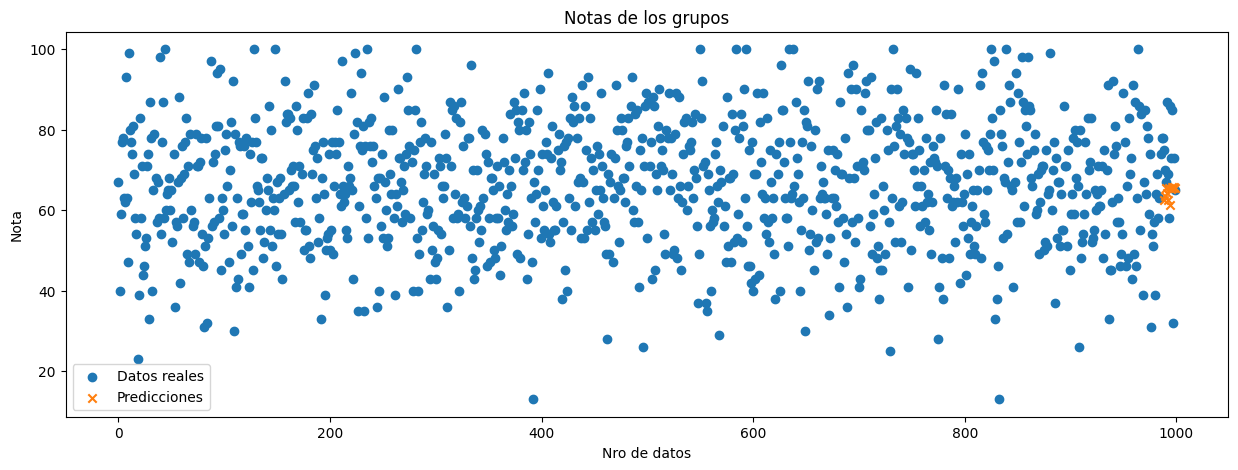

In [31]:
import matplotlib.pyplot as plt

# Visualizar los resultados como puntos en el plano
plt.figure(figsize=(15, 5))
plt.title("Notas de los grupos")
plt.xlabel("Nro de datos")
plt.ylabel("Nota")

# Graficar los datos como puntos
plt.scatter(range(len(all_data)), all_data, label='Datos reales', marker='o')
plt.scatter(range(len(train_data), len(train_data) + len(actual_predictions)), actual_predictions, label='Predicciones', marker='x')

plt.legend()  # Agrega una leyenda para diferenciar entre datos reales y predicciones
plt.show()

#Definiendo el Modelo LSTM

In [23]:
# La clase toma tres argumentos:
# el tamaño de entrada (input_size)
# el tamaño de la capa oculta (hidden_layer_size)
# el tamaño de salida (output_size)

class LSTM(torch.nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        # Capa rnn
        self.lstm = torch.nn.LSTM(input_size, hidden_layer_size)
        # Segunda capa LSTM
        self.lstm2 = torch.nn.LSTM(hidden_layer_size, hidden_layer_size)
        # Agregar una capa Dropout
        self.dropout = nn.Dropout(p=0.2)
        # Capa linea (full conected)
        self.linear = torch.nn.Linear(hidden_layer_size, output_size)
        # Estado oculto inicial de la red
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
      # Propagación hacia adelante a través de la capa LSTM
      lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1,-1), self.hidden_cell)
      # Propagación hacia adelante a través de la segunda capa LSTM
      lstm_out2, self.hidden_cell = self.lstm2(lstm_out.view(len(input_seq), 1, -1), self.hidden_cell)
      # capa Dropout
      dropout_out = self.dropout(lstm_out2)
      # Propagación hacia adelante a través de la capa lineal
      predictions=self.linear(dropout_out.view(len(input_seq),-1))

      # Devuelve todas las predicciones en la secuencia
      return predictions[-1]

El estado oculto inicial de la red se utiliza para almacenar información sobre la secuencia de entrada anterior. En una red neuronal recurrente (RNN), el estado oculto se actualiza en cada paso de tiempo y se utiliza para procesar la entrada en el siguiente paso de tiempo.

In [24]:
model=LSTM()
model

LSTM(
  (lstm): LSTM(1, 100)
  (lstm2): LSTM(100, 100)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [25]:
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [26]:
epochs=100

# Ciclo de entrenamiento
for i in range(epochs):
  # Ciclo de entrenamiento para cada secuencia de entrada
  for seq,label in train_inout_seq:
    # Reiniciar los gradientes
    optimizer.zero_grad()
    # Reiniciar el estado oculto de la red
    model.hidden_cell=(torch.zeros(1,1,model.hidden_layer_size),
                        torch.zeros(1,1,model.hidden_layer_size))
    # Propagación hacia adelante a través de la red
    y_pred=model(seq)
    # Calcular la pérdida para la predicción actual
    single_loss=loss_function(y_pred,label)
    # Propagación hacia atrás de la pérdida
    single_loss.backward()
    # Actualizar los pesos de la red
    optimizer.step()
  # Imprimir la pérdida cada 25 épocas
  if i%25==0:
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
# Imprimir la pérdida final
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.10608893
epoch:  25 loss: 0.07457671
epoch:  50 loss: 0.08108854
epoch:  75 loss: 0.09544357
epoch:  99 loss: 0.1221601665


In [27]:
fut_pred=12

# Obtener los últimos datos de entrenamiento normalizados
test_inputs=train_data_normalized[-train_window:].tolist()

# Establecer el modelo en modo de evaluación
model.eval()

# Realizar predicciones futuras
for i in range(fut_pred):
  # Crear una secuencia de entrada a partir de los últimos datos de prueba
  seq=torch.FloatTensor(test_inputs[-train_window:])
  # Desactivar el cálculo de gradientes para la predicción
  with torch.no_grad():
    # Establecer el estado oculto inicial en cero
    model.hidden=(torch.zeros(1,1,model.hidden_layer_size),
                      torch.zeros(1,1,model.hidden_layer_size))

    # Realizar la predicción y agregarla a los datos de prueba
    test_inputs.append(model(seq).item())

# Invertir la normalización y obtener las predicciones reales
actual_predictions=scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

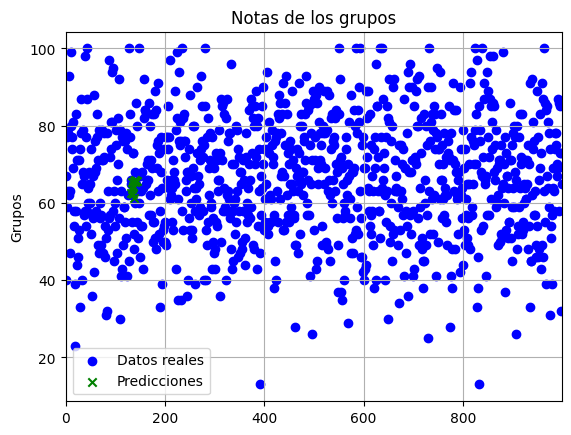

In [33]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(132, 144, 1)

plt.title("Notas de los grupos")
plt.ylabel("Grupos")
plt.grid(True)
plt.autoscale(axis='x', tight=True)

# Utiliza scatter para mostrar puntos en lugar de plot
plt.scatter(range(len(data['math score'])), data['math score'], color='blue', marker='o', label='Datos reales')
plt.scatter(x, actual_predictions, color='green', marker='x', label='Predicciones')

plt.legend()  # Agrega una leyenda para diferenciar las series de datos
plt.show()